# AlphaZero

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math
from math import exp
from collections import namedtuple
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Hyperparameters

In [ ]:
# State #
BOARD_SIZE = (9,9)

# Agent #
C_PUCT_INIT = 2.5
C_PUCT_DECAY = 0.05
C_PUCT_MIN = 1.0

TAU_INIT = 1.0
TAU_DECAY = 0.05
TAU_MIN = 1e-4

NUM_OF_SIMULATION = 400 # MCTS 시뮬레이션

# Main #
NUM_EPOCHS = 1 #100 # (self play 데이터 이용한) 학습 횟수
NUM_GAMES = 2 #50 # self play 횟수
BATCH_SIZE = 1 #8 #32 # (NUM_GAMES의 약수)

LEARNING_RATE = 0.0005
WEIGHT_DECAY = 1e-4

## State

In [ ]:
class State:
    def __init__(self, my_actions=None, enemy_actions=None, last_move=None, board_size=BOARD_SIZE, move_history=None):
        # my_actions, enemy_actions: 플레이어별로 두었던 위치(액션 인덱스)
        self.my_actions = [] if my_actions is None else my_actions
        self.enemy_actions = [] if enemy_actions is None else enemy_actions

        self.board_size = board_size  # (9, 9)

        self.action_space = range(self.board_size[0]*self.board_size[1]) # 0 ~ 80
        self.num_actions = len(self.action_space)

        # 전체 이동 순서를 저장 (각 원소는 (action, player) 형태)
        # player: 1이면 현재 "my" (선공) 플레이어, -1이면 상대 (후공) 플레이어
        if move_history is None:
            self.move_history = []
        else:
            self.move_history = move_history

        # 마지막 수 기록 (직전 수)
        self.last_move = last_move

        # 바둑판 생성: 2 x board_size 배열, 0번 채널은 선공, 1번 채널은 후공
        self.board = self._create_board(self.my_actions, self.enemy_actions)

        self.available_actions = self._get_available_actions()
        self.winning_condition = 5

        self.win_cache = None
        self.lose_cache = None

    def _create_board(self, my_actions, enemy_actions):
        total_board = np.zeros(shape=(2, *self.board_size), dtype=np.int8)
        if my_actions:
            rows, cols = zip(*[(action // self.board_size[1], action % self.board_size[1])
                                 for action in my_actions])
            total_board[0][rows, cols] = 1
        if enemy_actions:
            rows, cols = zip(*[(action // self.board_size[1], action % self.board_size[1])
                                 for action in enemy_actions])
            total_board[1][rows, cols] = 1
        return total_board

    def _get_available_actions(self):
        occupied = np.logical_or(self.board[0], self.board[1]).flatten()
        return [i for i in self.action_space if not occupied[i]]

    def _check_win_from_last_move(self, board, last_move):
        if last_move is None:
            return False

        row = last_move // self.board_size[1]
        col = last_move % self.board_size[1]
        directions = [
            (0, 1),   # 가로
            (1, 0),   # 세로
            (1, 1),   # 대각선 ↘
            (1, -1)   # 대각선 ↙
        ]

        for dx, dy in directions:
            count = 1
            # 정방향 체크
            r, c = row + dx, col + dy
            while (0 <= r < self.board_size[0] and
                   0 <= c < self.board_size[1] and
                   board[r, c] == 1):
                count += 1
                r, c = r + dx, c + dy

            # 역방향 체크
            r, c = row - dx, col - dy
            while (0 <= r < self.board_size[0] and
                   0 <= c < self.board_size[1] and
                   board[r, c] == 1):
                count += 1
                r, c = r - dx, c - dy

            if count >= self.winning_condition:
                return True

        return False

    def is_win(self):
        if self.win_cache is None:
            self.win_cache = self._check_win_from_last_move(self.board[0], self.last_move)
        return self.win_cache

    def is_lose(self):
        if self.lose_cache is None:
            enemy_last_move = self.enemy_actions[-1] if self.enemy_actions else None
            self.lose_cache = self._check_win_from_last_move(self.board[1], enemy_last_move)
        return self.lose_cache

    def is_draw(self):
        return not (self.is_win() or self.is_lose()) and len(self.available_actions) == 0

    def is_done(self):
        return self.is_win() or self.is_lose() or len(self.available_actions) == 0

    def is_going_first(self):
        return (len(self.my_actions) + len(self.enemy_actions)) % 2 == 0

    def next(self, action):
        # 다음 상태로 전이할 때, move_history에 새로운 수 추가
        # 현재 플레이어의 수: is_going_first()가 True이면 선공, 아니면 후공 (여기서는 1, -1로 표기)
        current_player = 1 if self.is_going_first() else -1
        new_move_history = self.move_history.copy()
        new_move_history.append((action, current_player))

        # 현재 플레이어(내)의 액션 업데이트
        my_actions = self.my_actions.copy()
        my_actions.append(action)
        # 다음 상태에서는 플레이어 역할이 swap되므로, move_history도 함께 전달
        return State(self.enemy_actions, my_actions, action, self.board_size, new_move_history)

    def _render_board_to_str(self):
        board = self.board[0] + self.board[1] * -1 if self.is_going_first() else self.board[0] * -1 + self.board[1]
        mapping = {0: 'Ⅹ', 1: '●', -1: '○'} # 1: 선공 black stone / -1: 후공 white stone
        last_move_symbol_b = '♥'
        last_move_symbol_w = '♡'

        col_legend = '   ' + '  '.join(map(str, range(self.board_size[1])))
        row_legend = []

        last_row, last_col = None, None
        if self.last_move is not None:
            last_row = self.last_move // self.board_size[1]
            last_col = self.last_move % self.board_size[1]

        for i, row in enumerate(board):
            cell_symbols = []
            for j, val in enumerate(row):
                if last_row is not None and i == last_row and j == last_col:
                    # 마지막 착수가 선공(흑)인지 후공(백)인지 구분
                    if board[i, j] == 1:
                        cell_symbols.append(last_move_symbol_b)  # 선공(흑) 착수
                    elif board[i, j] == -1:
                        cell_symbols.append(last_move_symbol_w)  # 후공(백) 착수
                    else:
                        cell_symbols.append(mapping[val])  # 혹시 빈칸이면 원래 값 유지
                else:
                    cell_symbols.append(mapping[val])

            row_str = ' '.join(cell_symbols)
            row_legend.append(f"{i:2} {row_str}")

        return '\n'.join([col_legend] + row_legend)

    def __call__(self):
        return self.board[:2]

    def __str__(self):
        return self._render_board_to_str()

## Environment

In [ ]:
class TicTacToeEnv:
    def __init__(self):
        self.state = State()
        self.reward = {'win': 10, 'lose': -10, 'draw': 0, 'continue': 0}

    def reset(self):
        self.state = State()
        return self.state

    def step(self, action):
        # 현재 상태에서 action을 두고, 다음 상태로 전환할 때 move_history도 업데이트됨
        my_actions = self.state.my_actions.copy()
        enemy_actions = self.state.enemy_actions.copy()

        my_actions.append(action)
        # 현재 플레이어가 둔 후 move_history 업데이트는 State.next()에서 처리
        next_state = State(my_actions, enemy_actions, self.state.last_move, self.state.board_size, self.state.move_history + [(action, 1 if self.state.is_going_first() else -1)])
        # 턴 교체: 현재 내 액션은 상대의 액션 리스트에 들어가게 함
        self.state = State(self.state.enemy_actions, my_actions, action, self.state.board_size, next_state.move_history)

        if next_state.is_win():
            reward, done = self.reward['win'], True
        elif next_state.is_draw():
            reward, done = self.reward['draw'], True
        elif next_state.is_lose():
            reward, done = self.reward['lose'], True
        else:
            reward, done = self.reward['continue'], False

        return self.state, next_state, reward, done

    def render(self):
        """
        최종 바둑판 렌더링 시, 각 돌 위에 전체 이동 순서를 표시합니다.
        move_history를 이용하여 각 액션(0~80)이 몇 번째 수인지 알아냅니다.
        """
        # 전체 바둑판: 현재 state에서 돌은 아래와 같이 표시합니다.
        # is_going_first()에 따라 돌의 색(부호)을 정합니다.
        board = self.state.board[0] - self.state.board[1] if self.state.is_going_first() else self.state.board[1] - self.state.board[0]

        fig, ax = plt.subplots(figsize=(5, 5))

        # 그리드 그리기
        for x in range(self.state.board_size[0]):
            ax.plot([0, self.state.board_size[0] - 1], [x, x], color='black', linewidth=1)
            ax.plot([x, x], [0, self.state.board_size[1] - 1], color='black', linewidth=1)

        # move_history를 바탕으로, 각 액션의 순서를 사전으로 만듭니다.
        # key: pos (0~80), value: move order (1부터 시작)
        move_order = {}
        for order, (action, _) in enumerate(self.state.move_history, start=1):
            move_order[action] = order

        # 돌을 그림 (x, y 좌표)
        for y in range(self.state.board_size[0]):
            for x in range(self.state.board_size[1]):
                pos = y * self.state.board_size[1] + x
                if board[y, x] == 1:  # Black
                    ax.plot(x, y, 'o', markersize=25, color='black')
                    if pos in move_order:
                        ax.text(x, y, str(move_order[pos]),
                                color='white', ha='center', va='center', fontweight='bold')
                elif board[y, x] == -1:  # White
                    ax.plot(x, y, 'o', markersize=25, color='white', markeredgecolor='black')
                    if pos in move_order:
                        ax.text(x, y, str(move_order[pos]),
                                color='black', ha='center', va='center', fontweight='bold')

        ax.patch.set_facecolor('wheat') # wheat / goldenrod
        ax.set_xlim(-0.5, self.state.board_size[0] - 0.5)
        ax.set_ylim(-0.5, self.state.board_size[1] - 0.5)
        ax.set_xticks(range(self.state.board_size[0]))
        ax.set_yticks(range(self.state.board_size[1]))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        ax.grid(False)
        ax.invert_yaxis()

        plt.show()

### Test

   0  1  2  3  4  5  6  7  8
 0 Ⅹ ○ ○ ○ ○ ● ● ● ●
 1 ● ● ● Ⅹ ○ Ⅹ Ⅹ Ⅹ Ⅹ
 2 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ ● Ⅹ Ⅹ Ⅹ
 3 Ⅹ Ⅹ Ⅹ Ⅹ ● Ⅹ Ⅹ Ⅹ Ⅹ
 4 Ⅹ Ⅹ Ⅹ ● Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 5 Ⅹ Ⅹ ● Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 6 Ⅹ ♥ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 7 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ ○ ○
 8 ○ ○ ○ ○ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
is first player? : False
is win : False
is draw : False
is lose : True
is done : True
0.0008325576782226562


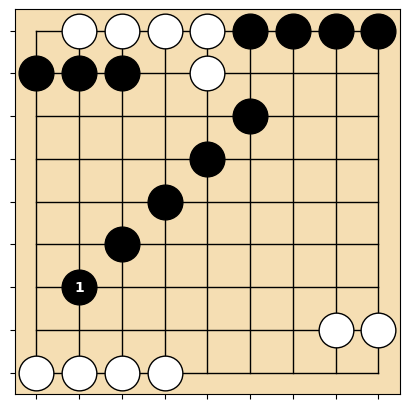

In [ ]:
import time

my_list = list(range(23, 48, 8)) + list(range(5,12))
enemy_list = [1,2,3,4,13] + list(range(70,76))

e = TicTacToeEnv()
s = State(my_list, enemy_list)
e.state = s
e.step(55)

start = time.time()
print(e.state)
print(f"is first player? : {e.state.is_going_first()}")
print(f"is win : {e.state.is_win()}")
print(f"is draw : {e.state.is_draw()}")
print(f"is lose : {e.state.is_lose()}")
print(f"is done : {e.state.is_done()}")

print(time.time() - start)

e.render()

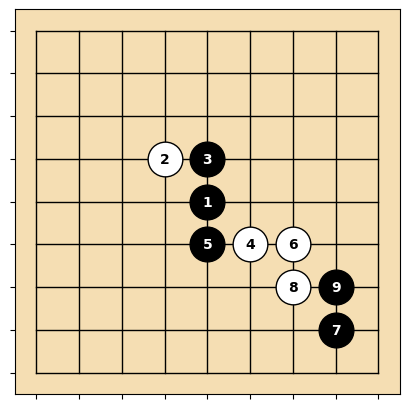

In [ ]:
env = TicTacToeEnv()
state = env.reset()

moves = [40, 30, 31, 50, 49, 51, 70, 60, 61]
done = False
for move in moves:
    state, next_state, reward, done = env.step(move)
    if done:
        break

env.render()

## Net

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            identity = self.downsample(identity)

        x += identity
        x = self.relu(x)

        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, config, zero_init_residual=False):
        super().__init__()
        block, n_blocks, channels = config
        self.in_channels = channels[0]

        # Initial Conv Layer
        self.conv1 = nn.Conv2d(2, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)

        # Residual Layers
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1])

        # Global Average Pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def get_resnet_layer(self, block, n_blocks, channels, stride=1):
        layers = []
        for i in range(n_blocks):
            if i == 0:
                layers.append(block(self.in_channels, channels, downsample=(self.in_channels != channels)))
            else:
                layers.append(block(channels, channels))
            self.in_channels = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avgpool(x)  # Output shape: (batch_size, channels, 1, 1)
        return x

In [ ]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

config = ResNetConfig(block=BasicBlock, n_blocks=[2, 2], channels=[32, 32])

class AlphaZeroNet(nn.Module):
    def __init__(self, board_size=BOARD_SIZE, config=config):
        super(AlphaZeroNet, self).__init__()
        _, _, channels = config
        self.board_size = board_size

        self.resnet = ResNet(config=config)

        # Policy Head
        self.policy_head = nn.Sequential(
            nn.Conv2d(channels[-1], 2, kernel_size=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2, board_size[0] * board_size[1]),
            nn.Softmax(dim=1)
        )

        # Value Head
        self.value_head = nn.Sequential(
            nn.Conv2d(channels[-1], 1, kernel_size=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.resnet(x)  # Shape: (batch_size, channels, 1, 1)

        # Policy Head
        policy = self.policy_head(x)

        # Value Head
        value = self.value_head(x)

        return policy, value

## MCTS Node

In [ ]:
class Node:
    def __init__(self, state, agent, parent=None, action=None, p=None):
        self.agent = agent
        self.parent_node = parent
        self.child_nodes = []
        self.state = state
        self.action = action
        self.n = 0 # 시행 횟수
        self.w = 0 # 보상 누계 (누적된 가치)
        self.p = p # 해당 액션을 선택할 확률 from policy net

    def expand(self):
        if not self.is_fully_expanded():
            self.child_nodes = [
                Node(
                    state=self.state.next(action),
                    agent=self.agent,
                    parent=self,
                    action=action,
                    p=self.agent.get_prior_prob(self.state, action)
                )
                for action in self.state.available_actions
            ]

    def select(self):
        if not self.is_fully_expanded():
            return self

        if not self.child_nodes:
            return None

        child_visits = np.array([child.n for child in self.child_nodes])
        child_values = np.array([-child.w / max(child.n, 1) for child in self.child_nodes])
        child_priors = np.array([child.p for child in self.child_nodes])

        q_values = child_values
        u_values = (
            self.agent.c_puct
            * child_priors
            * np.sqrt(self.n)
            / (1 + child_visits)
        )

        ucb_scores = q_values + u_values
        best_child_idx = np.argmax(ucb_scores)

        return self.child_nodes[best_child_idx]

    def backup(self, value):
        node = self
        while node is not None:
            node.n += 1
            node.w += value
            node = node.parent_node
            value = -value

    def is_fully_expanded(self):
        return len(self.child_nodes) == len(self.state.available_actions)

    def get_terminal_value(self):
        if self.state.is_lose():
            return -1  # 패배
        if self.state.is_draw():
            return 0  # 무승부
        return 1  # 승리

## Agent

In [ ]:
class AlphaZeroAgent:
    def __init__(self, network, env):
        self.network = network
        self.env = env

        self.num_simulations = NUM_OF_SIMULATION
        self.tau = TAU_INIT # temperature
        self.c_puct = C_PUCT_INIT

    def get_policy(self, state):
        root = Node(state=state, agent=self)

        for _ in range(self.num_simulations):
            node = root

            # Selection
            while node.is_fully_expanded() and not node.state.is_done():
                node = node.select()

            value = 0

            # Expansion and Evaluation
            if not node.state.is_done():
                node.expand()
                value = self._predict_value(node.state)
            else:
                value = node.get_terminal_value()

            # Backpropagation
            node.backup(value)

        action_probs = np.zeros(self.env.state.num_actions)
        for child in root.child_nodes:
            action_probs[child.action] = child.n

        if self.tau == 0:
            best_action = np.argmax(action_probs)
            action_probs = np.zeros_like(action_probs)
            action_probs[best_action] = 1.0
        else:
            action_probs = action_probs ** (1.0 / self.tau)
            action_probs = action_probs / np.sum(action_probs)

        return action_probs.astype(np.float32)

    def _compute_policy(self, root_node):
        policy = np.zeros(self.env.state.num_actions, dtype=np.float32)
        for child in root_node.child_nodes:
            ###
            print(f"Action: {child.action}, Visit count: {child.n}")
            ###
            policy[child.action] = child.n
        print()

        policy = np.clip(policy, 1e-8, None)

        if self.tau == 0:
            # tau가 0인 경우 argmax로 결정 (test)
            best_action = np.argmax(policy)
            final_policy = np.zeros_like(policy)
            final_policy[best_action] = 1.0
            return final_policy

        # tau > 0인 경우 정규화
        tau = max(self.tau, 1e-8)
        policy = policy ** (1 / tau)
        return policy / np.sum(policy)

    def _simulate(self, node):
        if node.state.is_done():
            return node, node.get_terminal_value()

        if not node.is_fully_expanded():
            node.expand()
            value = self._predict_value(node.state)
            return node, value

        best_child = node.select()
        # 재귀적으로 시뮬레이션 수행하되, 자식 노드의 관점에서는 value가 반전됨
        leaf_node, value = self._simulate(best_child)
        return leaf_node, -value  # 부모 노드 관점에서는 value를 반전

    def get_prior_prob(self, state, action):
        with torch.no_grad():
            state_tensor = torch.tensor(state.board, dtype=torch.float32).unsqueeze(0).to(device)
            policy, _ = self.network(state_tensor)
            policy = policy.squeeze(0).cpu().numpy()
        return policy[action]

    def _predict_value(self, state):
        with torch.no_grad():
            state_tensor = torch.tensor(state.board, dtype=torch.float32).unsqueeze(0).to(device)
            _, value = self.network(state_tensor)
        return value.item()

    def random_action(self, state):
        return np.random.choice(state.available_actions)

## Self-play

(알파제로에서) 셀프플레이 25,000 게임, MCTS 시뮬레이션 1,600번

각 게임마다 처음 30번은 temp = 1, 나머지 move는 temp → 0

In [ ]:
def self_play(env, agent):
    states, mcts_policies, values = [], [], []
    state = env.reset()

    while not state.is_done():
        policy = agent.get_policy(state)
        action = np.random.choice(len(policy), p=policy)
        states.append(state.board)
        mcts_policies.append(policy)
        state, _, _, _ = env.step(action)

    env.render()

    print(f"is_going_first: {state.is_going_first()}")
    if state.is_win():
        outcome = 1
        print("win")
    elif state.is_draw():
        outcome = 0
        print("draw")
    else:
        outcome = -1
        print("lose")

    values = [outcome] * len(states)
    for i in range(len(values)):
        if i % 2 == 1:  # Every other move belongs to opponent
            values[i] = -values[i]

    return states, mcts_policies, values

### Policy visualization

In [ ]:
def visualize_heatmap(data, title="Policy Distribution", cmap="Blues",
                      figsize=(5, 5), annot=True, fmt=".3f"):
    if isinstance(data, np.ndarray):
        reshaped_data = data.reshape(BOARD_SIZE[0], BOARD_SIZE[1])
        df = pd.DataFrame(reshaped_data)
    plt.figure(figsize=figsize)

    sns.heatmap(df,
                annot=annot,
                fmt=fmt,
                cmap=cmap,
                cbar=False,
                square=True)

    plt.title(title)
    plt.tight_layout()
    plt.show()

### Self-play: Debugging

In [ ]:
def self_play(env, agent):
    states, mcts_policies, values = [], [], []
    state = env.reset()

    print("\nNew Game Starting...")

    move_count = 0

    if state.is_done():
        print("Warning: Game ended before any moves")
        return [], [], []

    while not state.is_done():
        move_count += 1
        print(f"\nMove {move_count}")

        policy = agent.get_policy(state)
        visualize_heatmap(policy)

        if np.sum(policy) == 0 or np.any(np.isnan(policy)):
            print("Warning: Invalid policy distribution")
            return [], [], []

        try:
            action = np.random.choice(len(policy), p=policy)
        except ValueError as e:
            print(f"Error in action selection: {e}")
            print("Policy:", policy)
            return [], [], []

        print(f"Selected action: {action}")
        print(f"Available actions: {state.available_actions}")

        if action not in state.available_actions:
            print(f"Warning: Invalid action selected! Action: {action}")
            continue

        states.append(state.board)
        mcts_policies.append(policy)

        prev_state = state # 이전 상태 저장
        state, _, _, _ = env.step(action)

        print("\nBoard after move:")
        print(env.state)

        # 상태 변화 확인
        if np.array_equal(prev_state.board, state.board):
            print("Warning: Board state didn't change after move")

        # 게임 종료 조건 상세 출력
        print(f"Is win: {state.is_win()}")
        print(f"Is lose: {state.is_lose()}")
        print(f"Is draw: {state.is_draw()}")

    print("\nGame finished!")
    print(f"Total moves: {move_count}")
    env.render()

    if move_count == 0:
        return [], [], []

    if state.is_win():
        outcome = 1
    elif state.is_draw():
        outcome = 0
    else:
        outcome = -1

    values = [outcome] * len(states)
    for i in range(len(values)):
        if i % 2 == 1:
            values[i] = -values[i]

    if len(states) != len(mcts_policies) or len(states) != len(values):
        print("Warning: Data arrays have inconsistent lengths")
        return [], [], []

    return states, mcts_policies, values

## Train

In [ ]:
def train(network, optimizer, data, batch_size=20):
    network.train()
    total_loss = 0

    states = torch.tensor(np.concatenate([d[0] for d in data]), dtype=torch.float32).to(device)
    policies = torch.tensor(np.concatenate([d[1] for d in data]), dtype=torch.float32).to(device)
    values = torch.tensor(np.concatenate([d[2] for d in data]), dtype=torch.float32).to(device)

    # 데이터셋과 DataLoader 생성
    dataset = TensorDataset(states, policies, values)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for batch_states, batch_policies, batch_values in dataloader:
        batch_states = batch_states.to(device)
        batch_policies = batch_policies.to(device)
        batch_values = batch_values.to(device)

        pred_policies, pred_values = network(batch_states)

        pred_policies = torch.softmax(pred_policies, dim=-1)
        policy_loss = -torch.sum(batch_policies * torch.log(pred_policies + 1e-6), dim=1).mean()
        value_loss = ((batch_values - pred_values.view(-1)) ** 2).mean()

        loss = policy_loss + value_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

## Evaluate

→ 메서드 이름 변경 (기존의 best net이랑 현재 net 대결해서 현재 net 승률 (55%) 넘으면 best net 업데이트)

+ temp = 0 으로 설정해야 함

In [ ]:
def evaluate_network(best_net, current_net, env, num_games=50):
    current_agent = AlphaZeroAgent(current_net, env)
    best_agent = AlphaZeroAgent(best_net, env)

    current_net_wins, best_net_wins, draws = 0, 0, 0

    for i in tqdm(range(num_games)):
        state = env.reset()

        while not state.is_done():
            if state.is_going_first():
                # 현재 네트워크의 행동
                policy = current_agent.get_policy(state)
            else:
                # 이전 베스트 네트워크의 행동
                policy = best_agent.get_policy(state)

            action = np.random.choice(len(policy), p=policy)
            state, _, _, _ = env.step(action)

        # 게임 결과 확인
        if state.is_win():
            if state.is_going_first():
                current_net_wins += 1
            else:
                best_net_wins += 1
        elif state.is_draw():
            draws += 1
        else:
            if state.is_going_first():
                best_net_wins += 1
            else:
                current_net_wins += 1

    print(f"Evaluation: Current Net Wins: {current_net_wins}, Best Net Wins: {best_net_wins}, Draws: {draws}")
    return current_net_wins, best_net_wins

## Main

In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def save_checkpoint(model, optimizer, epoch, file_path):
    torch.save({
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'epoch': epoch
    }, file_path)
    print(f"Checkpoint saved\n")

In [ ]:
def load_checkpoint(model, optimizer, file_path):
    if os.path.exists(file_path):
        checkpoint = torch.load(file_path)
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        start_epoch = checkpoint['epoch'] + 1  # 다음 에포크부터 시작
        print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")
    else:
        start_epoch = 0
        print("No checkpoint found. Starting from scratch.")
    return start_epoch

In [ ]:
try_num = input() # (omok-test 테스트 완료) omok_1

env = TicTacToeEnv()
net = AlphaZeroNet().to(device)
agent = AlphaZeroAgent(net, env)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

best_net = AlphaZeroNet().to(device)
best_net.load_state_dict(net.state_dict())

folder_path = '/content/drive/MyDrive/Colab Notebooks/kanghwa'
file_path = os.path.join(folder_path, f'checkpoint{try_num}.pth')
start_epoch = load_checkpoint(net, optimizer, file_path)

losses = []
win_rates = []

for epoch in range(start_epoch, NUM_EPOCHS):
    data = []
    print(f"<< Epoch {epoch + 1}/{NUM_EPOCHS} >>")

    for i in tqdm(range(NUM_GAMES)):
        if i <= (NUM_GAMES * 0.1):
            agent.c_puct = C_PUCT_INIT
            agent.tau = TAU_INIT
        else:
            agent.c_puct = max(C_PUCT_MIN, round(C_PUCT_INIT*exp(-C_PUCT_DECAY*i), 4))
            agent.tau = max(TAU_MIN, round(TAU_INIT*exp(-TAU_DECAY*i), 4))

        ###
        print(f"\n{i + 1}/{NUM_GAMES}")
        print(f"C_puct: {agent.c_puct}")
        print(f"Tau: {agent.tau}")
        ###

        game_data = self_play(env, agent)
        data.append(game_data)

    loss = train(net, optimizer, data, batch_size=BATCH_SIZE)
    losses.append(loss)
    print(f"\nEpoch {epoch + 1} Loss: {loss}\n")

    # if (epoch + 1) % 2 == 0:
    current_net_wins, best_net_wins = evaluate_network(best_net, net, env, NUM_GAMES)
    win_rate = current_net_wins / NUM_GAMES
    win_rates.append(win_rate)

    if win_rate >= 0.55:
        print("Update best network.\n")
        best_net.load_state_dict(net.state_dict())

    save_checkpoint(best_net, optimizer, epoch, file_path)

omok-test
Checkpoint loaded. Resuming from epoch 1


<ipython-input-20-b83b391fbe96>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(losses) + 1), losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(2, len(win_rates) * 2 + 1, 2), win_rates, label='Win Rate')
plt.xlabel('Epochs')
plt.ylabel('Win Rate')
plt.title('Win Rate Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Test

In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/kanghwa

/content/drive/MyDrive/Colab Notebooks/kanghwa


In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks/kanghwa


In [ ]:
import agents

In [ ]:
def test(agent, env, num_games=10, player_type='random', random_first=True):
    agent_wins = 0
    draws = 0
    losses = 0

    agent.tau = 0

    randd = agents.Random(env)
    ab = agents.AlphaBeta(env)
    mcs = agents.MCS(env)
    mcts = agents.MCTS(env)

    for game in range(num_games):
        print(f"GAME {game + 1}/{num_games}")
        state = env.reset()

        # 게임 시작 전 랜덤하게 선공/후공 결정
        if random_first:
            agent_first = np.random.choice([True, False])
            print(f"===Agent goes {'first (●)' if agent_first else 'second (○)'}===")
        else:
            agent_first = True  # Default: 에이전트가 선공

        print(". . . . . . . . . . . . . . .")

        while not state.is_done():
            is_agent_turn = (state.is_going_first() == agent_first)

            if is_agent_turn:  # Agent's turn
                player = "Agent's"
                policy = agent.get_policy(state)
                action = np.random.choice(len(policy), p=policy)
            else:  # Opponent's turn
                while True:  # 올바른 action이 설정될 때까지 반복
                    if player_type == 'human':
                        player = "Your"
                        print("[Choose your action: (x-coord) * (y-coord) - 1]")
                        action = int(input("Enter your move (0~80) : "))
                        while action not in state.available_actions:
                            action = int(input("Invalid move. Try again : "))
                        break
                    elif player_type == 'random':
                        player = "Random player's"
                        action = randd.get_action(state)
                        break
                    elif player_type == 'alphabeta':
                        player = "Alpha-beta player's"
                        action = ab.get_action(state)
                        break
                    elif player_type == 'mcs':
                        player = "MCS player's"
                        action = mcs.get_action(state)
                        break
                    elif player_type == 'mcts':
                        player = "MCTS player's"
                        action = mcts.get_action(state)
                        break
                    else:
                        print(f"Warning: Invalid player type '{player_type}'")
                        print("Available player types: 'human', 'random', 'alphabeta', 'mcs', 'mcts'")
                        player_type = input("Player type: ").lower()
                        if player_type not in ['human', 'random', 'alphabeta', 'mcs', 'mcts']:
                            print("Invalid input. Please try again.")
                            continue

            state, _, _, _ = env.step(action)

            print(f"{player} turn")
            print(env.state)
            print(". . . . . . . . . . . . . . .")

        env.render()
        # 게임 결과 처리
        if state.is_lose():
            if (state.is_going_first() == agent_first):
                print("Opponent wins!\n")
                losses += 1
            else:
                print("Agent wins!\n")
                agent_wins += 1
        elif state.is_draw():
            print("It's a draw!\n")
            draws += 1

    print("\nTest Results:")
    print(f"Agent Wins: {agent_wins}")
    print(f"Draws: {draws}")
    print(f"Agent Losses: {losses}")

In [ ]:
# Test
agent = AlphaZeroAgent(best_net, env)

In [ ]:
# vs. Random Agent
test(agent, env, num_games=1, player_type='random')

In [ ]:
# vs. Alpha-Beta Agent
# test(agent, env, num_games=1, player_type='alphabeta')

In [ ]:
# vs. MCS Agent
# test(agent, env, num_games=1, player_type='mcs')

GAME 1/1
===Agent goes first (●)===
. . . . . . . . . . . . . . .
Agent's turn
   0  1  2  3  4  5  6  7  8
 0 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ ♥ Ⅹ Ⅹ Ⅹ
 1 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 2 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 3 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 4 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 5 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 6 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 7 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 8 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
. . . . . . . . . . . . . . .


ValueError: 'a' cannot be empty unless no samples are taken

In [ ]:
# vs. MCTS Agent
test(agent, env, num_games=1, player_type='mcts')

GAME 1/1
===Agent goes first (●)===
. . . . . . . . . . . . . . .
Agent's turn
   0  1  2  3  4  5  6  7  8
 0 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ ♥ Ⅹ Ⅹ Ⅹ
 1 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 2 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 3 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 4 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 5 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 6 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 7 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 8 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
. . . . . . . . . . . . . . .
MCTS player's turn
   0  1  2  3  4  5  6  7  8
 0 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ ● Ⅹ Ⅹ Ⅹ
 1 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 2 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 3 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 4 Ⅹ Ⅹ Ⅹ ♡ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 5 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 6 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 7 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 8 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
. . . . . . . . . . . . . . .
Agent's turn
   0  1  2  3  4  5  6  7  8
 0 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ ● Ⅹ Ⅹ Ⅹ
 1 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 2 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 3 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 4 Ⅹ Ⅹ Ⅹ ○ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 5 Ⅹ Ⅹ Ⅹ Ⅹ ♥ Ⅹ Ⅹ Ⅹ Ⅹ
 6 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 7 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 8 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
. . . . . . . . . . . . . . .
MCTS player's turn
   0  1  2  3  4  5  6  7  8
 0 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ ● Ⅹ Ⅹ Ⅹ
 1 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 2 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 3 Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ Ⅹ
 4 Ⅹ Ⅹ Ⅹ ○ Ⅹ 

ValueError: 'a' cannot be empty unless no samples are taken

In [ ]:
# vs. Human
test(agent, env, num_games=1, player_type='human')